# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet. 

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

In [1]:
import json
import os

from numpy.random import shuffle
from yt_dlp import YoutubeDL
import requests
import pickle as pk
import av
import pprint as pp
from opensearchpy import OpenSearch
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import numpy as np

FRAMES_DIR = "frames"
path = "downloads/"

host = 'localhost'
port = 9200

nova_host = 'api.novasearch.org'
nova_port = 443

user = 'user10' # Add your user name here.
password = '2025.grupo10' # Add your user password here. For testing only. Don't store credentials in code. 

local_user = 'admin'
local_pwd = '2025.Grupo10' # Add your local password here. For testing only. Don't store credentials in code.
index_name = user

DOWNLOAD_DIR = "downloads"
FRAMES_DIR = "frames"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

In [100]:
def download_video(video_id, url):
    output_path = os.path.join(DOWNLOAD_DIR, f"{video_id}.mp4")
    if os.path.exists(output_path):
        print(f"Already downloaded: {video_id}")
        return

    ydl_opts = {
        'outtmpl': output_path,
        'format': 'best[ext=mp4]/best',
        'quiet': False,
        'noplaylist': True,
        'retries': 3
    }

    try:
        with YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
    except Exception as e:
        print(f"Failed to download {video_id}: {str(e)}")


def is_youtube_video_available(id):
    try:
        oembed_url = f"https://www.youtube.com/oembed?url=http://www.youtube.com/watch?v={id}&format=json"
        response = requests.get(oembed_url)     
        if response.status_code != 200:
             return False
        
        url = f"https://www.youtube.com/watch?v={id}"
        
        response = requests.get(url)
        content = response.text

        # Check if the video is available by verifying the attribute "playabilityStatus"
        if 'playabilityStatus' in content:
            if '"status":"UNPLAYABLE"' in content:
                return False
            if '"status":"AGE_VERIFICATION_REQUIRED"' in content:
                return False
            if '"status":"LOGIN_REQUIRED"' in content:
                return False
            
       
        return True

    except Exception as e:
        print(f"Error checking video {id}: {str(e)}")
        return False

with open('../activity_net.v1-3.min.json', 'r') as json_data:
    moments_data = json.load(json_data)
    moments_data = moments_data['database']

with open('captions/train.json', 'r') as json_data:
    captions_data = json.load(json_data)

video_stats = []
for id, video_data in moments_data.items():
        num_moments = len(video_data.get('annotations', []))
        if "v_" + id not in captions_data:
             continue
        num_captions = len(captions_data["v_" + id]['sentences'])
        total = num_moments + num_captions
        video_stats.append({
            'id': id,
            'length': video_data.get('duration', ''),
            'resolution': video_data.get('resolution', ''),
            'num_moments': num_moments,
            'num_captions': num_captions,
            'url': video_data.get('url', ''),
            'total': total
        })

video_stats.sort(key=lambda x: x['total'], reverse=True)
top_videos = video_stats[:50]

top_10_videos = []
for video in top_videos:
    if is_youtube_video_available(video['id']) and len(top_10_videos) < 50:
        top_10_videos.append(video)



for video in top_10_videos:
     #print(f"Video url: {video['url']}")
     download_video(video['id'], video['url'])
     
     
with open('top_10_videos.pkl', 'wb') as f:
    pk.dump(top_10_videos, f)
    
with open('moments_data.pkl', 'wb') as f:
    pk.dump(moments_data, f)
    
with open('captions_data.pkl', 'wb') as f:
    pk.dump(captions_data, f)

Already downloaded: tuhHQ-lHIs4
Already downloaded: o1WPnnvs00I
Already downloaded: oGwn4NUeoy8
Already downloaded: -fjUWhSM6Hc
Already downloaded: qF3EbR8y8go
Already downloaded: DLJqhYP-C0k
Already downloaded: jBvGvVw3R-Q
Already downloaded: -rKS00dzFxQ
Already downloaded: VEDRmPt_-Ms
Already downloaded: v7o9uSu9AVI
Already downloaded: RJpWgi0EaUE
Already downloaded: lxMSX0Y0b8I
Already downloaded: cGNkR-JvaJs
Already downloaded: nOvrsb0XyGk
Already downloaded: FXb8rBMvol4
Already downloaded: jTMdMnbW9OI
Already downloaded: Eilil6FZhK8
Already downloaded: G7kqlq8WhRo
Already downloaded: OVRYoPA6h-Y
Already downloaded: ybcStSlBGPc
Already downloaded: sWaU9O4xzFE
Already downloaded: 9wtMJoqGTg0
Already downloaded: DMw9Cb_Xy2A
Already downloaded: Ffi7vDa3C2I
Already downloaded: -ap649M020k
Already downloaded: ekgfptN7tQk
Already downloaded: ynpvos7UFZo
Already downloaded: JRr3BruqS2Y
[youtube] Extracting URL: https://www.youtube.com/watch?v=8JKK6JayDeA
[youtube] 8JKK6JayDeA: Downloading

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

In [103]:
import os
import av

# Create the frames directory if it doesn't exist
os.makedirs(FRAMES_DIR, exist_ok=True)

videos = os.listdir(path)

for video in videos:
    video_name, _ = os.path.splitext(video)
    video_frames_dir = os.path.join(FRAMES_DIR, video_name)

    # Only process the frames of the video if the directory does not exist
    if os.path.exists(video_frames_dir):
        print(f"Frames already extracted for {video_name}. Skipping...")
        continue

    os.makedirs(video_frames_dir, exist_ok=True)
    print(f"Processing video: {video_name}")
    video_path = os.path.join(path, video)

    with av.open(video_path) as container:
        stream = container.streams.video[0]
        time_base = stream.time_base

        saved_seconds = set()

        for frame in container.decode(stream):
            if frame.pts is None:
                continue  # Skip frames without PTS

            timestamp_seconds = int(frame.pts * time_base)

            # Save only one frame per 2 seconds
            if timestamp_seconds % 2 == 0 and timestamp_seconds not in saved_seconds:
                saved_seconds.add(timestamp_seconds)
                frame_path = os.path.join(video_frames_dir, f"{video_name}_{timestamp_seconds:04d}.jpg")
                frame.to_image().save(frame_path, quality=80)
                print(f"Saved frame at {timestamp_seconds} seconds for {video_name}")


Processing video: tuhHQ-lHIs4
Saved frame at 0 seconds for tuhHQ-lHIs4
Saved frame at 2 seconds for tuhHQ-lHIs4
Saved frame at 4 seconds for tuhHQ-lHIs4
Saved frame at 6 seconds for tuhHQ-lHIs4
Saved frame at 8 seconds for tuhHQ-lHIs4
Saved frame at 10 seconds for tuhHQ-lHIs4
Saved frame at 12 seconds for tuhHQ-lHIs4
Saved frame at 14 seconds for tuhHQ-lHIs4
Saved frame at 16 seconds for tuhHQ-lHIs4
Saved frame at 18 seconds for tuhHQ-lHIs4
Saved frame at 20 seconds for tuhHQ-lHIs4
Saved frame at 22 seconds for tuhHQ-lHIs4
Saved frame at 24 seconds for tuhHQ-lHIs4
Saved frame at 26 seconds for tuhHQ-lHIs4
Saved frame at 28 seconds for tuhHQ-lHIs4
Saved frame at 30 seconds for tuhHQ-lHIs4
Saved frame at 32 seconds for tuhHQ-lHIs4
Saved frame at 34 seconds for tuhHQ-lHIs4
Saved frame at 36 seconds for tuhHQ-lHIs4
Saved frame at 38 seconds for tuhHQ-lHIs4
Saved frame at 40 seconds for tuhHQ-lHIs4
Saved frame at 42 seconds for tuhHQ-lHIs4
Saved frame at 44 seconds for tuhHQ-lHIs4
Saved fra

## OpenSearch configuration

In [2]:
# Create the client with SSL/TLS enabled, but hostname verification disabled.
"""client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (local_user, local_pwd),
    use_ssl = True,
    #url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)"""


client = OpenSearch(
    hosts = [{'host': nova_host, 'port': nova_port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (user, password),
    use_ssl = True,
    url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)


if client.indices.exists(index_name):

    resp = client.indices.open(index = index_name)
    print(resp)

    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index = index_name)
    pp.pprint(settings)

    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index = index_name)
    pp.pprint(mappings)

    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index = index_name))
else:
    print("Index does not exist.")


{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'user10': {'settings': {'index': {'creation_date': '1746701436467',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user10',
                                   'refresh_interval': '-1',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': '9vN_wZACT7yHRDy9vv6RSw',
                                   'version': {'created': '136387927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'user10': {'mappings': {'dynamic': 'strict',
                         'properties': {'caption_embedding': {'dimension': 512,
                                          

### Index Deletion

In [105]:
#This line is here to prevent you from inadvertently deleting data.

if client.indices.exists(index=index_name):
    # Delete the index.
    response = client.indices.delete(
        index = index_name
    )
    print('\nDeleting index:')
    print(response)


Deleting index:
{'acknowledged': True}


### Index Creation

In [106]:
index_body = {
    "settings": {
        "index": {
            "number_of_replicas": 0,
            "number_of_shards": 4,
            "refresh_interval": "-1",
            "knn": "true"
        }
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            "video_id": {"type": "keyword"},
            "video_url": {"type": "keyword"},            
            "video_length": {"type": "keyword"},
            "video_resolution": {"type": "keyword"},
            "frame_path": {"type": "keyword"},
            "frame_name": {"type": "keyword"},
            "caption_text": {"type": "text"},
            "caption_start_time": {"type": "float"},
            "caption_end_time": {"type": "float"},
            "frame_timestamp": {"type": "integer"},
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 768,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            },
            "caption_embedding": {
                "type": "knn_vector",
                "dimension": 512,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            },
            "image_base64": {
                    "type": "text",
                    "index": False,
                    "doc_values": False
                },
            "frame_embedding": {
                "type": "knn_vector",
                "dimension": 512,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            }
        }
    }
}

if client.indices.exists(index=index_name):
    print("Index already existed. You may force the new mappings.")
else:        
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index:')
    print(response)


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user10'}


### Sentence Embedding

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode_text(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

### Process the videos and captions

In [108]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel
import base64
import io
import os
import pickle as pk
import torch.nn.functional as F

# Load the larger CLIP model for 768-dimensional embeddings
model_image = AutoModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=torch.float32, attn_implementation="sdpa")
processor_image = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

video_data = []
top_10_videos = pk.load(open('top_10_videos.pkl', 'rb'))
moments_data = pk.load(open('moments_data.pkl', 'rb'))
captions_data = pk.load(open('captions_data.pkl', 'rb'))

print(f"Number of videos: {len(top_10_videos)}")

video_frame_docs = []

for video in top_10_videos:
    video_id = video['id']
    video_url = video['url']
    video_length = video['length']
    video_resolution = video['resolution']
    video_timestamps = captions_data["v_" + video_id]['timestamps']
    video_captions = captions_data["v_" + video_id]['sentences']
    video_frames_path = FRAMES_DIR + "/" + video_id

    sentence_embeddings = encode_text(video_captions)
    frames = sorted(os.listdir(video_frames_path))

    for frame_name in frames:
        frame_timestamp = int(frame_name.split("_")[-1].split(".")[0])
        frame_path = os.path.join(video_frames_path, frame_name)

        closest_caption_idx = 0
        min_diff = float('inf')
        for i, timestamp_range in enumerate(video_timestamps):
            start_time, end_time = timestamp_range
            if start_time <= frame_timestamp <= end_time:
                closest_caption_idx = i
                min_diff = 0
                break
            else:
                diff = min(abs(start_time - frame_timestamp), abs(end_time - frame_timestamp))
                if diff < min_diff:
                    min_diff = diff
                    closest_caption_idx = i

        caption = video_captions[closest_caption_idx]
        caption_timestamp_range = video_timestamps[closest_caption_idx]

        caption_start_time = caption_timestamp_range[0]
        caption_end_time = caption_timestamp_range[1]
        sentence_embedding = sentence_embeddings[closest_caption_idx].numpy().tolist()

        image = Image.open(frame_path).convert("RGB")
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG", quality=85)
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

        inputs = processor_image(images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            image_emb = model_image.get_image_features(**inputs)
            image_emb = F.normalize(image_emb, p=2, dim=1)

        frame_embedding = image_emb.squeeze(0).numpy().tolist()

        # Do the caption embedding using CLIP
        inputs = processor_image(text=caption, return_tensors="pt", padding=True)
        with torch.no_grad():
            query_emb = model_image.get_text_features(**inputs)
            query_emb = F.normalize(query_emb, p=2, dim=1)
        caption_embedding = query_emb.squeeze(0).numpy().tolist()
        

        doc = {
            "video_id": video_id,
            "video_url": video_url,
            "video_length": video_length,
            "video_resolution": video_resolution,
            "frame_path": frame_path,
            "frame_name": frame_name,
            "frame_timestamp": frame_timestamp,
            "caption_text": caption,
            "caption_start_time": caption_start_time,
            "caption_end_time": caption_end_time,
            "frame_embedding": frame_embedding,
            "caption_embedding": caption_embedding,
            "sentence_embedding": sentence_embedding,
            "image_base64": img_base64
        }
        video_frame_docs.append(doc)

with open('video_frame_docs.pkl', 'wb') as f:
    pk.dump(video_frame_docs, f)


Number of videos: 42


### Index the video data

In [109]:
video_frames = pk.load(open('video_frame_docs.pkl', 'rb'))

for doc_frames in video_frames:
    try:
        # Make sure frame_embedding is not None
        if doc_frames.get('frame_embedding') is None:
            print(f"Skipping document with missing frame_embedding: {doc_frames.get('frame_name', 'unknown')}")
            continue
            
        resp = client.index(index=index_name, body=doc_frames)
        print(resp['result'])
    except Exception as e:
        print(f"Error indexing document: {e}")
        # Optionally print the problematic document for debugging
        print(f"Problematic document: {doc_frames}")

client.indices.refresh(index=index_name)
count = client.count(index=index_name)
print("Document count:", count['count'])


created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created


# 2.4

## Queries

### Input - Text
### Output - Image


In [7]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel
import base64
import io

model_image = AutoModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=torch.float32, attn_implementation="sdpa")
processor_image = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Compute query CLIP embbeding to retrieve the most similar frames
def compute_query_embedding(query):
    inputs = processor_image(text=query, return_tensors="pt", padding=True)
    with torch.no_grad():
        query_emb = model_image.get_text_features(**inputs)
        query_emb = F.normalize(query_emb, p=2, dim=-1)
    return query_emb

query = "some people swimming"
query_embedding = compute_query_embedding(query)
query_embedding = query_embedding.squeeze(0).numpy().tolist()

# Perform the search
search_body = {
    "size": 2,
    "query": {
        "knn": {
          "frame_embedding": {
            "vector": query_embedding,
            "k": 2
          }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    # Optionally, you can also display the image using base64
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()

Search results:
Frame: -ap649M020k_0068.jpg, Score: 0.64439523
Frame: -ap649M020k_0062.jpg, Score: 0.6377553


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



** (xviewer:63818): CRITICAL **: 14:01:37.751: xviewer_image_get_file: assertion 'XVIEWER_IS_IMAGE (img)' failed

(xviewer:63818): GLib-GIO-CRITICAL **: 14:01:37.751: g_file_equal: assertion 'G_IS_FILE (file1)' failed


### Input - Image
### Output - Image


In [8]:
# Compute the image query embedding

def compute_image_query_embedding(image_path):
    image = Image.open(image_path)
    image = image.convert("RGB")

    buffered = io.BytesIO()
    image.save(buffered, format="JPEG", quality=85)

    inputs = processor_image(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        image_emb = model_image.get_image_features(**inputs)
        image_emb = F.normalize(image_emb, p=2, dim=1)

    return image_emb

image_path = "images/kitchen.jpg"  # Replace with your image path
query_embedding = compute_image_query_embedding(image_path)
query_embedding = query_embedding.squeeze(0).numpy().tolist()

search_body = {
    "size": 3,
    "query": {
        "knn": {
          "frame_embedding": {
            "vector": query_embedding,
            "k": 3
          }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    # Optionally, you can also display the image using base64
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()
    

Search results:
Frame: 539ByIcbUPs_0020.jpg, Score: 0.83014333
Frame: 539ByIcbUPs_0014.jpg, Score: 0.8090348
Frame: 539ByIcbUPs_0022.jpg, Score: 0.8029697


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

** (xviewer:63937): CRITICAL **: 14:01:54.868: xviewer_image_get_file: assertion 'XVIEWER_IS_IMAGE (img)' failed

(xviewer:63937): GLib-GIO-CRITICAL **: 14:01:54.868: g_file_equal: assertion 'G_IS_FILE (file1)' failed
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid 


** (xviewer:63937): CRITICAL **: 14:01:54.955: xviewer_image_get_file: assertion 'XVIEWER_IS_IMAGE (img)' failed

(xviewer:63937): GLib-GIO-CRITICAL **: 14:01:54.955: g_file_equal: assertion 'G_IS_FILE (file1)' failed


### Input: Text + Image
### Output: Image

In [9]:
## Compute the caption embedding with image embedding using CLIP
query = "blue"
image = "images/park.jpg"

image_emb = compute_image_query_embedding(image)
query_emb = compute_query_embedding(query)

# Sum the two embeddings and normalize
combined_embedding = (image_emb + query_emb) / 2
combined_embedding = combined_embedding.squeeze(0).numpy().tolist()

search_body = {
    "size": 3,
    "query": {
        "knn": {
          "frame_embedding": {
            "vector": combined_embedding,
            "k": 3
          }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    # Optionally, you can also display the image using base64
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()


Search results:
Frame: OVRYoPA6h-Y_0094.jpg, Score: 0.75944585
Frame: QZi1yBFRZzc_0064.jpg, Score: 0.7495712


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Frame: OVRYoPA6h-Y_0172.jpg, Score: 0.7491508


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



** (xviewer:64108): CRITICAL **: 14:02:13.436: xviewer_image_get_file: assertion 'XVIEWER_IS_IMAGE (img)' failed

(xviewer:64108): GLib-GIO-CRITICAL **: 14:02:13.436: g_file_equal: assertion 'G_IS_FILE (file1)' failed


### Input: Image + Image
### Output: Image

In [10]:
## Compute the caption embedding with image embedding using CLIP
image = "images/kids_school.jpg"
image2 = "images/sports.jpg"

image_emb = compute_image_query_embedding(image)
image2_emb = compute_image_query_embedding(image2)

combined_embedding = (image_emb + image2_emb) / 2
combined_embedding = combined_embedding.squeeze(0).numpy().tolist()

search_body = {
    "size": 2,
    "query": {
        "knn": {
          "frame_embedding": {
            "vector": combined_embedding,
            "k": 3
          }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    #caption_text = hit['_source']['caption_text']
    #print(f"Caption: {caption_text}")
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()


Search results:
Frame: sWaU9O4xzFE_0120.jpg, Score: 0.8603246
Frame: cGNkR-JvaJs_0156.jpg, Score: 0.8551998


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



** (xviewer:64226): CRITICAL **: 14:02:27.564: xviewer_image_get_file: assertion 'XVIEWER_IS_IMAGE (img)' failed

(xviewer:64226): GLib-GIO-CRITICAL **: 14:02:27.564: g_file_equal: assertion 'G_IS_FILE (file1)' failed


### 3.3.1

/tmp/ipykernel_5450/2106816441.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(captions_text_arr))


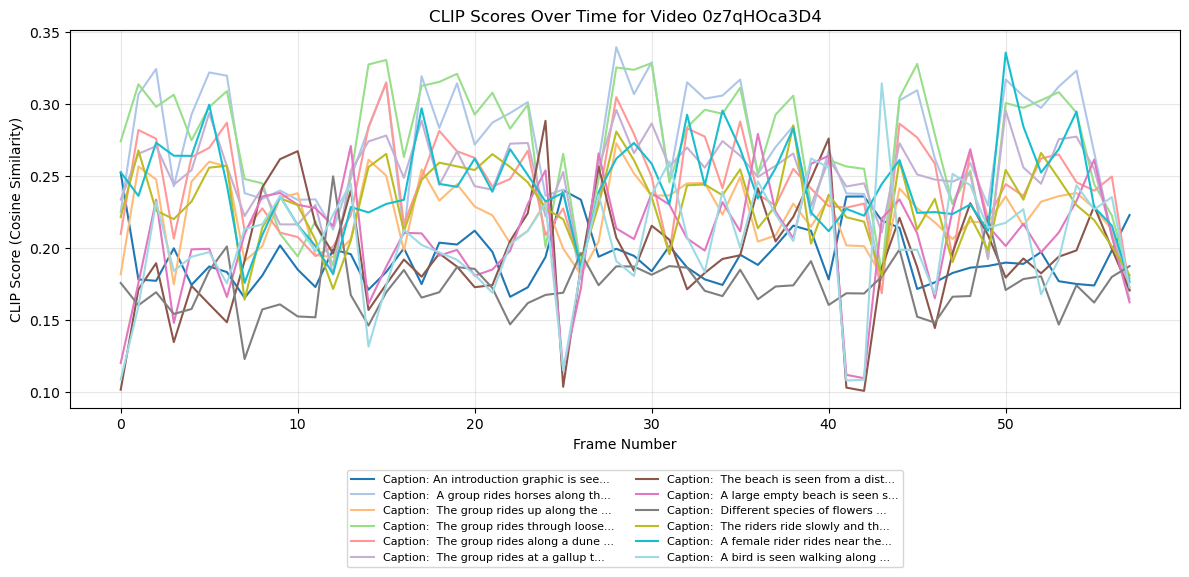


Peak moments for each caption:
Caption: 'An introduction graphic is seen with title....' - Peak at frame 0 with score 0.2522
Caption: ' A group rides horses along the coast line togethe...' - Peak at frame 28 with score 0.3393
Caption: ' The group rides up along the bluffs....' - Peak at frame 28 with score 0.2727
Caption: ' The group rides through loose sand and the horses...' - Peak at frame 15 with score 0.3304
Caption: ' The group rides along a dune section and through ...' - Peak at frame 15 with score 0.3145
Caption: ' The group rides at a gallup through the water and...' - Peak at frame 28 with score 0.2958
Caption: ' The beach is seen from a distance as the sun has ...' - Peak at frame 24 with score 0.2882
Caption: ' A large empty beach is seen seen from the shore....' - Peak at frame 36 with score 0.2791
Caption: ' Different species of flowers are seen....' - Peak at frame 12 with score 0.2498
Caption: ' The riders ride slowly and then it becomes later ...' - Peak at frame 38

In [17]:
# Seach for all the different captions of this video "0z7qHOca3D4"
video_id = "0z7qHOca3D4"
search_body = {
    "size": 500,
    "query": {
        "match": {
            "video_id": video_id
        }
    }
}
response = client.search(index=index_name, body=search_body)
captions_text_arr = []
for hit in response['hits']['hits']:
    caption_text = hit['_source']['caption_text']
    if caption_text not in captions_text_arr:
        captions_text_arr.append(caption_text)

captions_embeddings_arr = []
for hit in response['hits']['hits']:
    caption_embedding = hit['_source']['caption_embedding']
    if caption_embedding not in captions_embeddings_arr:
        captions_embeddings_arr.append(caption_embedding)

frame_images = []
for hit in response['hits']['hits']:
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    if image not in frame_images:
        frame_images.append(image)

frame_embeddings = []
for hit in response['hits']['hits']:
    frame_embedding = hit['_source']['frame_embedding']
    if frame_embedding not in frame_embeddings:
        frame_embeddings.append(frame_embedding)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.colors as mcolors


def compute_clip_scores(caption_embedding, frame_embeddings):
    # Reshape caption embedding for proper broadcasting
    caption_embedding = np.array(caption_embedding).reshape(1, -1)
    frame_embeddings_array = np.array(frame_embeddings)
    
    # Compute cosine similarity between caption and all frames
    similarities = cosine_similarity(caption_embedding, frame_embeddings_array)[0]
    return similarities

# Create figure and axis
plt.figure(figsize=(12, 6))

# Set up a colormap for different captions
colors = list(mcolors.TABLEAU_COLORS)
if len(captions_text_arr) > len(colors):
    # If we have more captions than colors, use a continuous colormap
    cmap = plt.cm.get_cmap('tab20', len(captions_text_arr))
    colors = [cmap(i) for i in range(len(captions_text_arr))]

# Time points (assuming frames are evenly spaced)
# If you have actual timestamps, replace this with those values
time_points = np.arange(len(frame_embeddings))

# For each caption, compute CLIP scores with all frames and plot
for i, (caption_text, caption_embedding) in enumerate(zip(captions_text_arr, captions_embeddings_arr)):
    # Compute CLIP scores
    clip_scores = compute_clip_scores(caption_embedding, frame_embeddings)
    
    # Plot the scores
    plt.plot(time_points, clip_scores, color=colors[i % len(colors)], 
             label=f"Caption: {caption_text[:30]}..." if len(caption_text) > 30 else f"Caption: {caption_text}")

# Add labels and title
plt.xlabel('Frame Number')
plt.ylabel('CLIP Score (Cosine Similarity)')
plt.title(f'CLIP Scores Over Time for Video {video_id}')

# Add grid
plt.grid(True, alpha=0.3)

# Add legend (with smaller font size if many captions)
font_size = 10 if len(captions_text_arr) <= 10 else 8
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
           ncol=2, fontsize=font_size)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Additional analysis: Find peak moments for each caption
print("\nPeak moments for each caption:")
for i, caption_text in enumerate(captions_text_arr):
    clip_scores = compute_clip_scores(captions_embeddings_arr[i], frame_embeddings)
    peak_frame = np.argmax(clip_scores)
    peak_score = clip_scores[peak_frame]
    print(f"Caption: '{caption_text[:50]}...' - Peak at frame {peak_frame} with score {peak_score:.4f}")



In [26]:
%pip install einops ftfy captum regex

import clip
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import visualization
import torch


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    #
    # print(logits_per_image)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cpu()* logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance, logits_per_text, logits_per_image

In [51]:
import matplotlib.pyplot as plt

def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        cmap = plt.get_cmap('jet')
        rgba_img = cmap(mask)
        heatmap = np.delete(rgba_img, 3, 2)
        cam = np.float32(heatmap) / np.max(heatmap)
        cam = (cam + img)/2
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    axs[1].imshow(vis);
    axs[1].axis('off');

from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    # print(text_scores)
    text_tokens=_tokenizer.encode(text)
    text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

In [52]:
clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [53]:
img_path = "images/kitchen.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["lamp"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show()

AttributeError: 'ResidualAttentionBlock' object has no attribute 'attn_probs'